Ben Katz

benkatz21@gmail.com

4/4/2022

BrainStation Data Science Boot Camp

# Introduction
In the last notebook I used machine learning linear models and statistical linear regressions to predict and gain insights on the transfer market values of soccer players in the Big 5 European Soccer Leagues. I used demographic and statistical information as my inputs. Here are is a summary of what I learned in the previous model. 

* Club Tier is an overpowering, but still powerful predictor
* Scoring is the most important statistic when club tier is removed

In this notebook I will attempt to build on the knowledge I have gained so far by doing the following two things. 

First, I will use boost models, specifically Gradient Boost regressors, AdaBoost regressors and XGBoost regressors to attempt to model the data set as a whole. These are more powerful models, so I feel they will be more appropriate on the whole data set as it is more diverse. The goal is to see which of the following would be the best boost regressor for this data set, and to see how appropriate these models are for this dataset. 

Second, I will be using partial dependence plots on the population as a whole and on specific `Position Group`s to isolate a subset of statistics to gain clearer insights than those provided by the models in the previous notebook. Let's begin. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Boosting Models
As stated above I will be using the following two types of boosting models in this section:
1. Gradient Boost Regressors
3. XG Boost Regressors

I will be using the entire population of soccer players, for reasons outlined above. I will start by running baseline models for each on untransformed and logarithmic transformed target variables. Then I will use a grid search to optimize hyper parameters. Before beginning I will need to read in the data, and import important packages.

## Importing packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Reading in the Data

In [ ]:
#feature variables
X = pd.read_csv('population.csv')
y = pd.read_csv('population_market_values.csv')

In [ ]:
#checking features set
X.head()

,Unnamed: 0,Age,90s,Gls/90,Ast/90,PK/90,Non PK Gls/90,Yellow Cards/90,Red Cards/90,xG/90,...,PKs won/90,PKs conceded/90,Loose Balls Recov/90,Aerial Battles Won/90,Aerial Battle Success Rate,Club Tier,European,Attacker Binary,pg_Defender,pg_Midfielder
0,0,20,10.8,0.000000,0.000000,0.000000,0.000000,0.648148,0.092593,0.009259,...,0.000000,0.0,10.370370,0.833333,40.909091,1,1,0,0,1
1,1,23,49.0,0.836735,0.367347,0.163265,0.673469,0.244898,0.000000,0.771429,...,0.102041,0.0,3.836735,0.224490,39.285714,6,1,1,0,0
2,2,21,39.4,1.091371,0.304569,0.126904,0.964467,0.126904,0.000000,0.827411,...,0.000000,0.0,3.451777,1.776650,53.846154,6,1,1,0,0
3,3,28,45.1,0.643016,0.243902,0.133038,0.509978,0.088692,0.000000,0.603104,...,0.022173,0.0,2.793792,1.596452,42.105263,6,1,1,0,0
4,4,29,57.3,0.715532,0.261780,0.174520,0.541012,0.017452,0.000000,0.584642,...,0.069808,0.0,5.689354,0.541012,26.956522,6,0,1,0,0


Need to drop the first column. It is a copy of the index. 

In [ ]:
#dropping
X.drop(['Unnamed: 0'], axis = 1, inplace=True)

#rechecking
X.head()

,Age,90s,Gls/90,Ast/90,PK/90,Non PK Gls/90,Yellow Cards/90,Red Cards/90,xG/90,non PK xG/90,...,PKs won/90,PKs conceded/90,Loose Balls Recov/90,Aerial Battles Won/90,Aerial Battle Success Rate,Club Tier,European,Attacker Binary,pg_Defender,pg_Midfielder
0,20,10.8,0.000000,0.000000,0.000000,0.000000,0.648148,0.092593,0.009259,0.046296,...,0.000000,0.0,10.370370,0.833333,40.909091,1,1,0,0,1
1,23,49.0,0.836735,0.367347,0.163265,0.673469,0.244898,0.000000,0.771429,0.553061,...,0.102041,0.0,3.836735,0.224490,39.285714,6,1,1,0,0
2,21,39.4,1.091371,0.304569,0.126904,0.964467,0.126904,0.000000,0.827411,0.598985,...,0.000000,0.0,3.451777,1.776650,53.846154,6,1,1,0,0
3,28,45.1,0.643016,0.243902,0.133038,0.509978,0.088692,0.000000,0.603104,0.450111,...,0.022173,0.0,2.793792,1.596452,42.105263,6,1,1,0,0
4,29,57.3,0.715532,0.261780,0.174520,0.541012,0.017452,0.000000,0.584642,0.431065,...,0.069808,0.0,5.689354,0.541012,26.956522,6,0,1,0,0


The features set looks good, now I can move onto the target variable. This represents the `Market Values in Millions` for each player. This is a valuation of how much a player is worth on the transfer market. This is explained in more detail in my second capstone notebook, which deals with EDA and hypothesis testing. 

In [ ]:
#checking
y.head()

,Unnamed: 0,Market Values in Millions
0,0,0.88
1,1,176.00
2,2,165.00
3,3,110.00
4,4,110.00


Again I need to drop the first column.

In [ ]:
#dropping
y.drop(['Unnamed: 0'], axis = 1, inplace=True)

#rechecking
y.head()

,Market Values in Millions
0,0.88
1,176.00
2,165.00
3,110.00
4,110.00


I am also going to turn y into a series for modeling purposes. 

In [ ]:
#turning y into a series
y = pd.Series(y['Market Values in Millions'])

#check step
y

0         0.880
1       176.000
2       165.000
3       110.000
4       110.000
         ...   
1489      0.825
1490      0.770
1491      0.660
1492      0.660
1493      0.330
Name: Market Values in Millions, Length: 1494, dtype: float64

Now I will check the shapes to make sure they match.

In [ ]:
print(f"There are {X.shape[0]} observations and {X.shape[1]} features in the feature data set")
print(f"There are {y.shape} observations in the target variable set")

There are 1494 observations and 66 features in the feature data set
There are (1494,) observations in the target variable set


The shapes match and now I can begin to model. 

## Boosting models
Before modeling I need to split the data into train and test sets. I am going to use a 60/40 train test split as this data is not very big. I also want to put less information into the training sets to avoid over-fitting.

### Train Test Split

In [ ]:
#importing train test splits
from sklearn.model_selection import train_test_split

#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.4,
                                                   random_state=21)

#checking shapes
print(f"Training Feature Set: {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"Training Target Set: {y_train.shape} rows")
print(f"Test Feature Set: {X_test.shape[0]} rows and {X_test.shape[1]} columns")
print(f"Test Target Set: {y_test.shape} rows")

Training Feature Set: 896 rows and 66 columns
Training Target Set: (896,) rows
Test Feature Set: 598 rows and 66 columns
Test Target Set: (598,) rows


### Transforming Target Sets
In the previous notebook, I found that transforming the target variable, `Market Values in Millions` helped the peformance of my model. This is because there is heavy skew in the data, due to a select few elite players being worth a lot more than the rest of the population. I will be transforming the target sets again to test against the original targets to see if it helps the performance of the boosting models as well. 

In [ ]:
#transforming whole pop
log_y = np.log(y + 1)

#transforming train
log_y_train = np.log(y_train + 1)

#transforming train
log_y_test = np.log(y_test + 1)

Now I am ready to begin modeling. 

### Baseline Gradient Boost Models
The first boosting model I will be using a Gradient Boosting Regressor from sklearn. A quick note on boosting models before beginning. 

Boosting is an ensemble method of modeling. The training set is sequentially fitted through a series of simple models. Each successive model updates based on where the previous model made mistakes. It uses an arbitrary loss function to determine what the model is struggling with most. At the end, it combines all the models and their mistakes into a more powerful model at the end. Here is a link that explains this in greater detail (https://www.ibm.com/cloud/learn/boosting#:~:text=Boosting%20is%20an%20ensemble%20learning,the%20weaknesses%20of%20its%20predecessor). 

Now I will begin modeling. I will be using the default parameter settings on the original and transformed target variable sets, which ever performs better will be kept moving forward. 

#### Original Target Baseline

In [ ]:
#importing gradient boost regressor
from sklearn.ensemble import GradientBoostingRegressor

#instantiating
gb_og_baseline = GradientBoostingRegressor(random_state=21)

#fitting
gb_og_baseline.fit(X_train, y_train)

#scoring
og_baseline_train_score = gb_og_baseline.score(X_train, y_train)
og_baseline_test_score = gb_og_baseline.score(X_test, y_test)

print(f"Original Baseline Training Score: {round(og_baseline_train_score, 2)}%")
print(f"Original Baseline Test Score: {round(og_baseline_test_score, 2)}%")

Original Baseline Training Score: 0.92%
Original Baseline Test Score: 0.68%


This is promising. It is already better than some of the optimized models in the previous notebook, though there is clear evidence of over-fitting. Now to test on the log transformed target variable.

#### Transformed Target Baseline

In [ ]:
#instantiating
gb_log_baseline = GradientBoostingRegressor(random_state=21)

#fitting
gb_log_baseline.fit(X_train, log_y_train)

#scoring
log_baseline_train_score = gb_log_baseline.score(X_train, log_y_train)
log_baseline_test_score = gb_log_baseline.score(X_test, log_y_test)

print(f"Transfomred Baseline Training Score: {round(log_baseline_train_score * 100, 2)}%")
print(f"Transformed Baseline Test Score: {round(log_baseline_test_score * 100, 2)}%")

Transfomred Baseline Training Score: 89.28%
Transformed Baseline Test Score: 69.97%


In [ ]:
gb_log_baseline.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(random_state=21)>

The transformed score is higher, so I will keep using the transformed set. 

### Hyper Parameter Optimization
In this section I will attempt to optimize the hyper parameters of this model. Here are the hyper parameters I need to optimize, in the order of which they will be optimized, and what they do. 

1. Loss
    * The loss function that is being used. 
2. learning_rate
    * Represents how fast the model learns. The higher the number the faster the model will learn.
3. n_estimators
    * The number of iterations the boosting model will run through
4. criterion
    * How improvement is measured between models
5. Subsample
    * The number of features taken into account in each model. Limiting the feature set can eliminate bias.
6. max_depth
    * How many decision stumps will be used at each level
7. min_samples_leaf
    * The minimum number of samples needed to be a leaf node.


To do this I will run a grid search. I will start by finding the right loss function. Then I will try to optimize the other parameters. I will cast a wide range of options for each and try to narrow down with each iteration. This is to avoid long run times.

For this first iteration, I will also be testing to see if scaling the data helps performance. I am only going to use a MinMaxScaler as I do not want any negative values for any features. This is to reduce run times..

#### Optimizing Loss Function and Scaler

In [ ]:
#importing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#creating a pipeling
gb_estimators = [('scaling', MinMaxScaler()),
                 ('model', GradientBoostingRegressor(loss = 'squared_error',
                                                     random_state=21))]

gb_pipeline = Pipeline(gb_estimators)

#creating loss grid
loss = ['squared_error','absolute_error', 'huber', 'quantile']

#creating parameter grid
gb_params = {'scaling': [MinMaxScaler(), None],
             'model__loss':loss}

#creating grid
gb_grid = GridSearchCV(gb_pipeline, gb_params, verbose = 2, cv = 3)

#fitting
gb_fitted = gb_grid.fit(X_train, log_y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..model__loss=squared_error, scaling=MinMaxScaler(); total time=   0.9s
[CV] END ..model__loss=squared_error, scaling=MinMaxScaler(); total time=   0.9s
[CV] END ..model__loss=squared_error, scaling=MinMaxScaler(); total time=   0.9s
[CV] END ............model__loss=squared_error, scaling=None; total time=   0.9s
[CV] END ............model__loss=squared_error, scaling=None; total time=   0.9s
[CV] END ............model__loss=squared_error, scaling=None; total time=   0.9s
[CV] END .model__loss=absolute_error, scaling=MinMaxScaler(); total time=   1.1s
[CV] END .model__loss=absolute_error, scaling=MinMaxScaler(); total time=   1.1s
[CV] END .model__loss=absolute_error, scaling=MinMaxScaler(); total time=   1.1s
[CV] END ...........model__loss=absolute_error, scaling=None; total time=   1.1s
[CV] END ...........model__loss=absolute_error, scaling=None; total time=   1.1s
[CV] END ...........model__loss=absolute_error, s

In [ ]:
#checking best params
gb_fitted.best_params_

{'model__loss': 'squared_error', 'scaling': None}

In [ ]:
#SCORE
print(f"Training Score: {round(gb_fitted.score(X_train, log_y_train )* 100 ,2)}")
print(f"Test Score: {round(gb_fitted.score(X_test, log_y_test) * 100 ,2)}%")

Training Score: 89.28
Test Score: 69.97%


#### Optimizing Hyper Parameters  1

Squared error is the best loss function, this is the default so it will not be specified in future models. We can also see that scaling did not help, so I am going to leave the data unscaled for future models. 

Now I am going to optimize the rest of the parameters listed above. I am going to start by finding a general range for all of the parameters. Then, I am gong to optimize 2 at a time on a smaller scale. If it is at the upper limit of the test range, I will run it again at that value until the other parameters are optimized, then I will test again on a higher range. 


In [ ]:
#Takes about 50. minutes to run
#creating a pipeling
gb_estimators_1 = [('model', GradientBoostingRegressor(random_state=21))]

gb_pipeline_1 = Pipeline(gb_estimators_1)

#creating param lists
learn_rate = [0.5, 1]
n_estimator = list(range(50, 151, 50))
criterion = ['friedman_mse', 'squared_error', 'absolute_error']
subsample = [0.5, 0.75]
max_depth = list(range(1, 10, 4))
min_samples_leaf = list(range(1, 22, 10))

#creating parameter grid
gb_params_1 = {'model__learning_rate':learn_rate,
               'model__n_estimators':n_estimator,
               'model__criterion':criterion,
               'model__subsample':subsample,
               'model__max_depth':max_depth,
               'model__min_samples_leaf':min_samples_leaf}

#creating grid
gb_grid_1 = GridSearchCV(gb_pipeline_1, gb_params_1, verbose=2, cv = 3)

#fitting grid
fitted_gb_grid_1 = gb_grid_1.fit(X_train, log_y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END model__criterion=friedman_mse, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   0.2s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   0.2s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   0.2s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   0.3s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   0.3s
[CV] END model__criterion=friedman_mse, model

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=   4.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=   4.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   6.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   6.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   6.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=   6.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=   6.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=   6.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=  13.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=  10.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=   9.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=  10.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=  20.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=  20.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=  20.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   5.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   5.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   5.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=  11.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=  11.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=  11.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=   8.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=   8.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=   8.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=  18.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=  17.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=  18.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   2.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   2.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   5.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   5.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   5.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   4.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   4.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   4.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=  11.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   7.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=  15.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=  16.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=  16.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   5.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=  10.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   9.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=  10.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=  10.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=  10.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=  21.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=  20.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=  21.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=  15.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=  16.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=  15.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=  32.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=  33.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=  32.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   8.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   8.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   7.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   7.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   7.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=  17.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=  17.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=  16.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=  11.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=  11.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=  10.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=  26.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=  26.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=  27.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   6.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   6.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   6.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   5.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   5.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=  13.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=  14.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   7.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   7.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=  19.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=  21.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=0.5, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=  19.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=   5.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   7.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   7.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=   8.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=   8.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=   8.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=  15.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=  15.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=  15.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=  12.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=  12.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=  12.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=  21.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=  21.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=  22.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   6.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   6.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   6.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   6.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   6.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   6.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=  13.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=   9.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=   9.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=   9.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=  19.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=  19.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=  20.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   2.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   5.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   5.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   5.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   4.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   4.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   4.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=  11.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=  11.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=  11.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   7.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=  16.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=  16.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=5, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=  17.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.5; total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=  10.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=  11.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=50, model__subsample=0.75; total time=  10.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=  13.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=  13.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.5; total time=  13.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=  15.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=  15.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=100, model__subsample=0.75; total time=  16.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=  20.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=  19.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.5; total time=  20.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=  15.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=  15.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=1, model__n_estimators=150, model__subsample=0.75; total time=  18.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.5; total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=  10.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   9.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=50, model__subsample=0.75; total time=   9.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   7.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.5; total time=   7.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=  20.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=  20.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=100, model__subsample=0.75; total time=  19.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=  12.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=  12.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.5; total time=  12.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=  30.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=  29.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=11, model__n_estimators=150, model__subsample=0.75; total time=  29.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   2.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.5; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=50, model__subsample=0.75; total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   5.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   4.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.5; total time=   5.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=  14.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=  14.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=  14.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   7.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.5; total time=   7.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=  21.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=  21.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


[CV] END model__criterion=absolute_error, model__learning_rate=1, model__max_depth=9, model__min_samples_leaf=21, model__n_estimators=150, model__subsample=0.75; total time=  22.3s


In [ ]:
#calling best estimator
best_gb_1 = fitted_gb_grid_1.best_estimator_

best_gb_1

Pipeline(steps=[('model',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=1,
                                           min_samples_leaf=21, random_state=21,
                                           subsample=0.75))])

In [ ]:
#best parameters
fitted_gb_grid_1.best_params_

{'model__criterion': 'friedman_mse',
 'model__learning_rate': 0.5,
 'model__max_depth': 1,
 'model__min_samples_leaf': 21,
 'model__n_estimators': 100,
 'model__subsample': 0.75}

In [ ]:

#train score
gb_1_train_score = fitted_gb_grid_1.score(X_train, log_y_train)

#test score
gb_1_test_score = fitted_gb_grid_1.score(X_test, log_y_test)

print(f"Training Score: {round(gb_1_train_score * 100, 2)}%")
print(f"Test Score: {round(gb_1_test_score * 100, 2)}%")


Training Score: 80.33%
Test Score: 65.76%


The test score actually decreased by 4% from the baseline model to 65.76%. I am going to try and optimize further, but if this trend continues, I will just take the default model as the best model. 

Above we see our best parameters. I can keep the following in place for the remaining models. 
* criterion: friedman_mse
    * Like with the loss function, once the best one is found it does not need to be changed. This is the default so it will not be listed. 
* subsample: 0.75
    * This could be optimized further, but I am much more concerned with optimizing the other hyper parameters
    
In the next model I will attempt to optimized max_depth and n_estimators. I am going to leave the min_samples_leaf and learning rate at the values listed above. I will optimize these later. This is to avoid long run times. 


#### Optimizing max_depth and n_estimators

* max_depth: I am going to test 3 values: 1, 2, 3. Since the 1 beat out 5 in the last grid, these are the only three possible options for the optimized max_depth

* n_estimators: I am going to try the following values: 75, 100, 125. Similar to the reasons listed above, because 100 estimators beat out 50 and 150 estimators in the last grid, I am going to test the midpoints to narrow it down further. 

In [ ]:
#creating a pipeling
gb_estimators_2 = [('model', GradientBoostingRegressor(random_state=21))]

gb_pipeline_2 = Pipeline(gb_estimators_2)

#creating param lists

#setting to optimized number in last grid
learn_rate = [0.5]

#new range
n_estimator = [75, 100, 125]

#found to be the best
criterion = ['friedman_mse']

#setting to optimized number in last grid
subsample = [0.75]

# new range
max_depth = [1, 2, 3]

#setting to optimized number in last grid
min_samples_leaf = [21]

#creating parameter grid
gb_params_2 = {'model__learning_rate':learn_rate,
               'model__n_estimators':n_estimator,
               'model__criterion':criterion,
               'model__subsample':subsample,
               'model__max_depth':max_depth,
               'model__min_samples_leaf':min_samples_leaf}

#creating grid
gb_grid_2 = GridSearchCV(gb_pipeline_2, gb_params_2, verbose=2, cv = 3)

#fitting grid
fitted_gb_grid_2 = gb_grid_2.fit(X_train, log_y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END model__criterion=friedman_mse, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=75, model__subsample=0.75; total time=   0.2s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=75, model__subsample=0.75; total time=   0.2s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=75, model__subsample=0.75; total time=   0.2s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=   0.3s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.5, model__max_depth=1, model__min_samples_leaf=21, model__n_estimators=100, model__subsample=0.75; total time=   0.3s
[CV] END model__criterion=friedman_mse

Now that the grid is fit I'm go to check the best parameters and the score of the model. 

In [ ]:
fitted_gb_grid_2.best_params_

{'model__criterion': 'friedman_mse',
 'model__learning_rate': 0.5,
 'model__max_depth': 1,
 'model__min_samples_leaf': 21,
 'model__n_estimators': 100,
 'model__subsample': 0.75}

The same values for max_depth and n_estimators showed up again. This is the same model that we got in the previous iteration. 

In [ ]:
#train score
gb_2_train_score = fitted_gb_grid_2.score(X_train, log_y_train)

#test score
gb_2_test_score = fitted_gb_grid_2.score(X_test, log_y_test)

print(f"Training Score: {round(gb_2_train_score * 100, 2)}%")
print(f"Test Score: {round(gb_2_test_score * 100, 2)}%")


Training Score: 80.33%
Test Score: 65.76%


The test accuracy remained the same at **65.76**, which is unsuprising given it is the same model. Now I will move on to the next grid, where I will optimize n_estimators again, min_samples_leaf, and learning rate. 

#### Optimizing n_estimators, min_samples_leaf, and learning rate

These are the only three variables yet to be optimized. Here is what I will do for this iteration of my gradient boost model. 

* n_estimators: I am going to shrink the range to 90-110. If the value is still 100, I am going to assume that is the optimized value for this hyper parameter

* learning rate : I am going to test 4 values here. 0.5 represented the minimum value, so I need to dive a little lower. I'm going to go by eighths up to 0.625. This will midpoint the range of from the first grid, while expanding pretty far down the learning rate scale. 

* min_samples_leaf: This was the highest value in the range, so I need to expand upwards. I will be testing values 20, 30, 40.

In [ ]:
#creating a pipeling
gb_estimators_3 = [('model', GradientBoostingRegressor(random_state=21))]

gb_pipeline_3 = Pipeline(gb_estimators_3)

#creating param lists

#setting to optimized number in last grid
learn_rate = [0.125, 0.25, 0.5, 0.625]

#new range
n_estimator = [90, 100, 110]

#found to be the best
criterion = ['friedman_mse']

#setting to optimized number in last grid
subsample = [0.75]

# new range
max_depth = [1]

#setting to optimized number in last grid
min_samples_leaf = list(range(20, 41, 10))

#creating parameter grid
gb_params_3 = {'model__learning_rate':learn_rate,
               'model__n_estimators':n_estimator,
               'model__criterion':criterion,
               'model__subsample':subsample,
               'model__max_depth':max_depth,
               'model__min_samples_leaf':min_samples_leaf}

#creating grid
gb_grid_3 = GridSearchCV(gb_pipeline_3, gb_params_3, verbose=2, cv = 3)

#fitting grid
fitted_gb_grid_3 = gb_grid_3.fit(X_train, log_y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=90, model__subsample=0.75; total time=   0.2s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=90, model__subsample=0.75; total time=   0.2s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=90, model__subsample=0.75; total time=   0.2s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=100, model__subsample=0.75; total time=   0.3s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=100, model__subsample=0.75; total time=   0.3s
[CV] END model__criterion=

In [ ]:
#checking params
fitted_gb_grid_3.best_params_

{'model__criterion': 'friedman_mse',
 'model__learning_rate': 0.125,
 'model__max_depth': 1,
 'model__min_samples_leaf': 20,
 'model__n_estimators': 110,
 'model__subsample': 0.75}

In [ ]:
#train score
gb_3_train_score = fitted_gb_grid_3.score(X_train, log_y_train)

#test score
gb_3_test_score = fitted_gb_grid_3.score(X_test, log_y_test)

print(f"Training Score: {round(gb_3_train_score * 100, 2)}%")
print(f"Test Score: {round(gb_3_test_score * 100, 2)}%")

Training Score: 72.93%
Test Score: 69.8%


Now we are starting to get somewhere. The model is much less over fit than the previous version of the model We can also see that the test score of **69.8** is above the baseline for the first time. 

I am going to keep the *min_samples_leaf* at 20, as it essentially stayed the same as the previous grid. 

That leaves 2 more hyper-parameters to optimize: *learning_rate* and *n_estimators*. I will discuss the plan for these two hyper-parameters in the next section. 

#### Optimizing n_estimators and learning rate

The learning rate dropped significantly in the last grid, from **0.5** to **0.125** Because our model is learning slower, it makes sense to test out higher values of n_estimators. Because these are the only two hyper-parameters left to score, I can increase the number of parameters being test. The ranges that will tested are shown below. 

* n_estimators: Starting at 110, and counting up to 210 by 20. 
* learning rate : We only need to test lower values so I will test from 0.025 to 0.125 counting by 0.025.

Now to run the grid again.

In [ ]:
#creating a pipelin3 4
gb_estimators_4 = [('model', GradientBoostingRegressor(random_state=21))]

gb_pipeline_4 = Pipeline(gb_estimators_4)

#creating param lists

#setting to optimized number in last grid
learn_rate = [0.125, 0.025, 0.05, 0.075, 0.1]

#new range
n_estimator = list(range(110, 211, 20))

#found to be the best
criterion = ['friedman_mse']

#setting to optimized number in last grid
subsample = [0.75]

# new range
max_depth = [1]

#setting to optimized number in last grid
min_samples_leaf = [20]

#creating parameter grid
gb_params_4 = {'model__learning_rate':learn_rate,
               'model__n_estimators':n_estimator,
               'model__criterion':criterion,
               'model__subsample':subsample,
               'model__max_depth':max_depth,
               'model__min_samples_leaf':min_samples_leaf}

#creating grid
gb_grid_4 = GridSearchCV(gb_pipeline_4, gb_params_4, verbose=2, cv = 3)

#fitting grid
fitted_gb_grid_4 = gb_grid_4.fit(X_train, log_y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=110, model__subsample=0.75; total time=   0.3s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=110, model__subsample=0.75; total time=   0.3s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=110, model__subsample=0.75; total time=   0.3s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=130, model__subsample=0.75; total time=   0.3s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=130, model__subsample=0.75; total time=   0.3s
[CV] END model__criterio

In [ ]:
#best params
fitted_gb_grid_4.best_params_

{'model__criterion': 'friedman_mse',
 'model__learning_rate': 0.125,
 'model__max_depth': 1,
 'model__min_samples_leaf': 20,
 'model__n_estimators': 150,
 'model__subsample': 0.75}

In [ ]:
#train score
gb_4_train_score = fitted_gb_grid_4.score(X_train, log_y_train)

#test score
gb_4_test_score = fitted_gb_grid_4.score(X_test, log_y_test)

print(f"Training Score: {round(gb_4_train_score * 100, 2)}%")
print(f"Test Score: {round(gb_4_test_score * 100, 2)}%")

Training Score: 75.09%
Test Score: 71.06%


We have officially past the best score from Lasso Regression models in the previous model (**70%**) with a score of **71.07&**. I am going to run one more model to try and improve on the learning rate and n_estimators again. This will be the final gradient boosting model I will run. 

#### Final Gradient Boost Model
Again I am trying to optimize *learning_rate* and *n_estimators*. Right now I know that the ideal *learning_rate* is between 0.125 and 0.175, so i will test in this range using 0.05 as a the step rate. I know that the ideal *n_estimators* is between 140 and 160, so i will count this range with a step rate of 5. If it does not improve on the previous iteration, then I will just use the last model as the best model.

In [ ]:
#creating a pipelin3 4
gb_estimators_final = [('model', GradientBoostingRegressor(random_state=21))]

gb_pipeline_final = Pipeline(gb_estimators_final)

#creating param lists

#setting to optimized number in last grid
learn_rate = np.arange(125, 176, 5)/1000

#new range
n_estimator = list(range(140, 161, 5))

#found to be the best
criterion = ['friedman_mse']

#setting to optimized number in last grid
subsample = [0.75]

# new range
max_depth = [1]

#setting to optimized number in last grid
min_samples_leaf = [20]

#creating parameter grid
gb_params_final = {'model__learning_rate':learn_rate,
               'model__n_estimators':n_estimator,
               'model__criterion':criterion,
               'model__subsample':subsample,
               'model__max_depth':max_depth,
               'model__min_samples_leaf':min_samples_leaf}

#creating grid
gb_grid_final = GridSearchCV(gb_pipeline_final, gb_params_final, verbose=2, cv = 3)

#fitting grid
fitted_gb_grid_final = gb_grid_final.fit(X_train, log_y_train)

Fitting 3 folds for each of 55 candidates, totalling 165 fits
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=140, model__subsample=0.75; total time=   0.4s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=140, model__subsample=0.75; total time=   0.4s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=140, model__subsample=0.75; total time=   0.4s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=145, model__subsample=0.75; total time=   0.4s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.125, model__max_depth=1, model__min_samples_leaf=20, model__n_estimators=145, model__subsample=0.75; total time=   0.4s
[CV] END model__criteri

In [ ]:
#checking best params
fitted_gb_grid_final.best_params_

{'model__criterion': 'friedman_mse',
 'model__learning_rate': 0.145,
 'model__max_depth': 1,
 'model__min_samples_leaf': 20,
 'model__n_estimators': 140,
 'model__subsample': 0.75}

The *learning_rate* increase to **0.145**, and *n_estimators* decreased to **140**. Now to check the scores to see if there was an improvement. 

In [ ]:
#train score
gb_final_train_score = fitted_gb_grid_final.score(X_train, log_y_train)

#test score
gb_final_test_score = fitted_gb_grid_final.score(X_test, log_y_test)

print(f"Training Score: {round(gb_final_train_score * 100, 2)}%")
print(f"Test Score: {round(gb_final_test_score * 100, 2)}%")

Training Score: 75.71%
Test Score: 70.8%


There was a slight drop in performance. I am going to use *fitted_gb_grid_4* as the optimal model.

## Optimized Model Examination
Now that an optimal model has been created, I am going to dig a little deeper. First I am going to transform predictions from the features set to see how good the model is at predicting actual market values. Then I am going to look under the hood to see which features are the most influential in this model.

### Predictions for actual. 

This process will be the same as the one performed for each of the optimized lasso regressions in the previous notebook. I will create a set of predictions using the optimized model. Then I will un-transform using *np.expm1*. Finally, I will find the r-squared value between the prediction set and the set of true market values. This will tell us how the model performs predicting actual data. 

In [ ]:
from sklearn.metrics import r2_score

#concatenating
X_concat = pd.concat([X_train, X_test])
y_concat = pd.concat([y_train, y_test])


#creating prediction set
gb_predict = fitted_gb_grid_4.predict(X_concat)

#untransforming prediction set
gb_predict_actual = np.expm1(gb_predict)

#scoring
untranformed_r_squared_gb = r2_score(gb_predict_actual, y_concat)

print(f"This model predicts {round(untranformed_r_squared_gb * 100, 2)}% the actual market value variability")

This model predicts 17.41% the actual market value variability


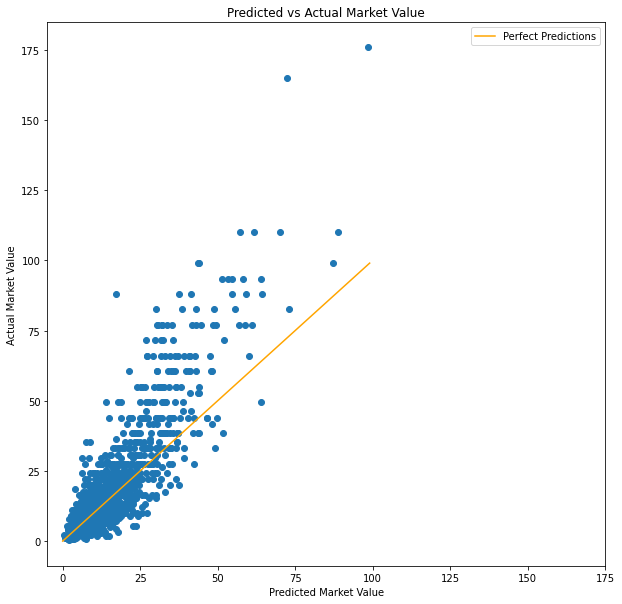

In [ ]:
#plotting true vs predicted market values
#square for ideal scale
plt.figure(figsize=(10, 10))
plt.scatter(gb_predict_actual, y_concat)
#creating perfect prediction line
plt.plot(range(0, 100), range(0,100), c = 'orange', label = 'Perfect Predictions')
plt.xlabel('Predicted Market Value')
plt.ylabel('Actual Market Value')
#setting equal to y-axis
plt.xticks(range(0, 176, 25))
plt.legend()
plt.title('Predicted vs Actual Market Value')
plt.show()

In [ ]:
#checking correlation
from scipy.stats import pearsonr

pearsonr(gb_predict_actual, y_concat)

(0.8764193789449323, 0.0)

Again we see that model is consistently underpredicting values, as most of the actual market values are higher than the predicted values. This is what is causing the r-squared value to be so low, despite the fact that model is picking up on linear trends in the data. This is performing about as well as a lasso regression. Now I will look at feature importance.

### Feature Importance

To do this I will need to re fit the model manually. 

In [ ]:
# for reference 
fitted_gb_grid_4.best_params_

{'model__criterion': 'friedman_mse',
 'model__learning_rate': 0.125,
 'model__max_depth': 1,
 'model__min_samples_leaf': 20,
 'model__n_estimators': 150,
 'model__subsample': 0.75}

In [ ]:
#insantiating
optimal_gb = GradientBoostingRegressor(criterion='friedman_mse',
                                       random_state = 21,
                                       learning_rate=0.125,
                                       max_depth=1,
                                       min_samples_leaf=20,
                                       n_estimators=150,
                                       subsample=0.17)

#fitting
optimal_gb.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.125, max_depth=1, min_samples_leaf=20,
                          n_estimators=150, random_state=21, subsample=0.17)

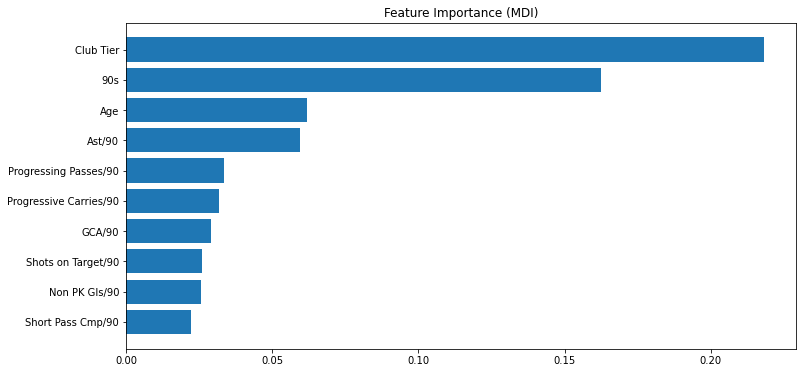

In [ ]:
#pulling feature importance
gb_feature_importance = optimal_gb.feature_importances_

#sorting index and cols
sorted_idx_gb = np.argsort(gb_feature_importance)
sorted_cols_gb = np.array(X.columns)[sorted_idx_gb]

#need last 10 columns, those represent the top columns
top_10_cols_gb = sorted_cols_gb[-10:]
top_10_features_gb = gb_feature_importance[sorted_idx_gb[-10:]]     


# top_ten_idx_gb

# top_ten_cols_gb = np.array(X.columns)[top_ten_idx]

# top_ten_cols_gb

pos = np.arange(top_10_features_gb.shape[0]) + 0.5
plt.figure(figsize=(12, 6))
plt.barh(pos, top_10_features_gb, align="center")
plt.yticks(pos, np.array(top_10_cols_gb))
plt.title("Feature Importance (MDI)")
plt.show()

The metric here is **mean decrease impurity**, which is essentially the probability that feature is used to split a node at any given level of the gradient boost model.

This matches up with the lasso regressions run in the previous notebook. In each of the models shown, `Club Tier`, `90s` and `Age` had the strongest practical effects. From there we can see that chance creation (`Ast/90` and `GCA/90`) is the next most important skill. After that it is the ability to move the ball forward (the two progessive/progressing features) and scoring/shooting. This again brings up the issue of opportunity vs. skill, but that has already been brought up numerous times. 

Below I am going to plot partial depedency plots for all of the stats in the plot above. These will show the effect of the given statistic assuming the rest of the statistics are kept constant at their mean.  

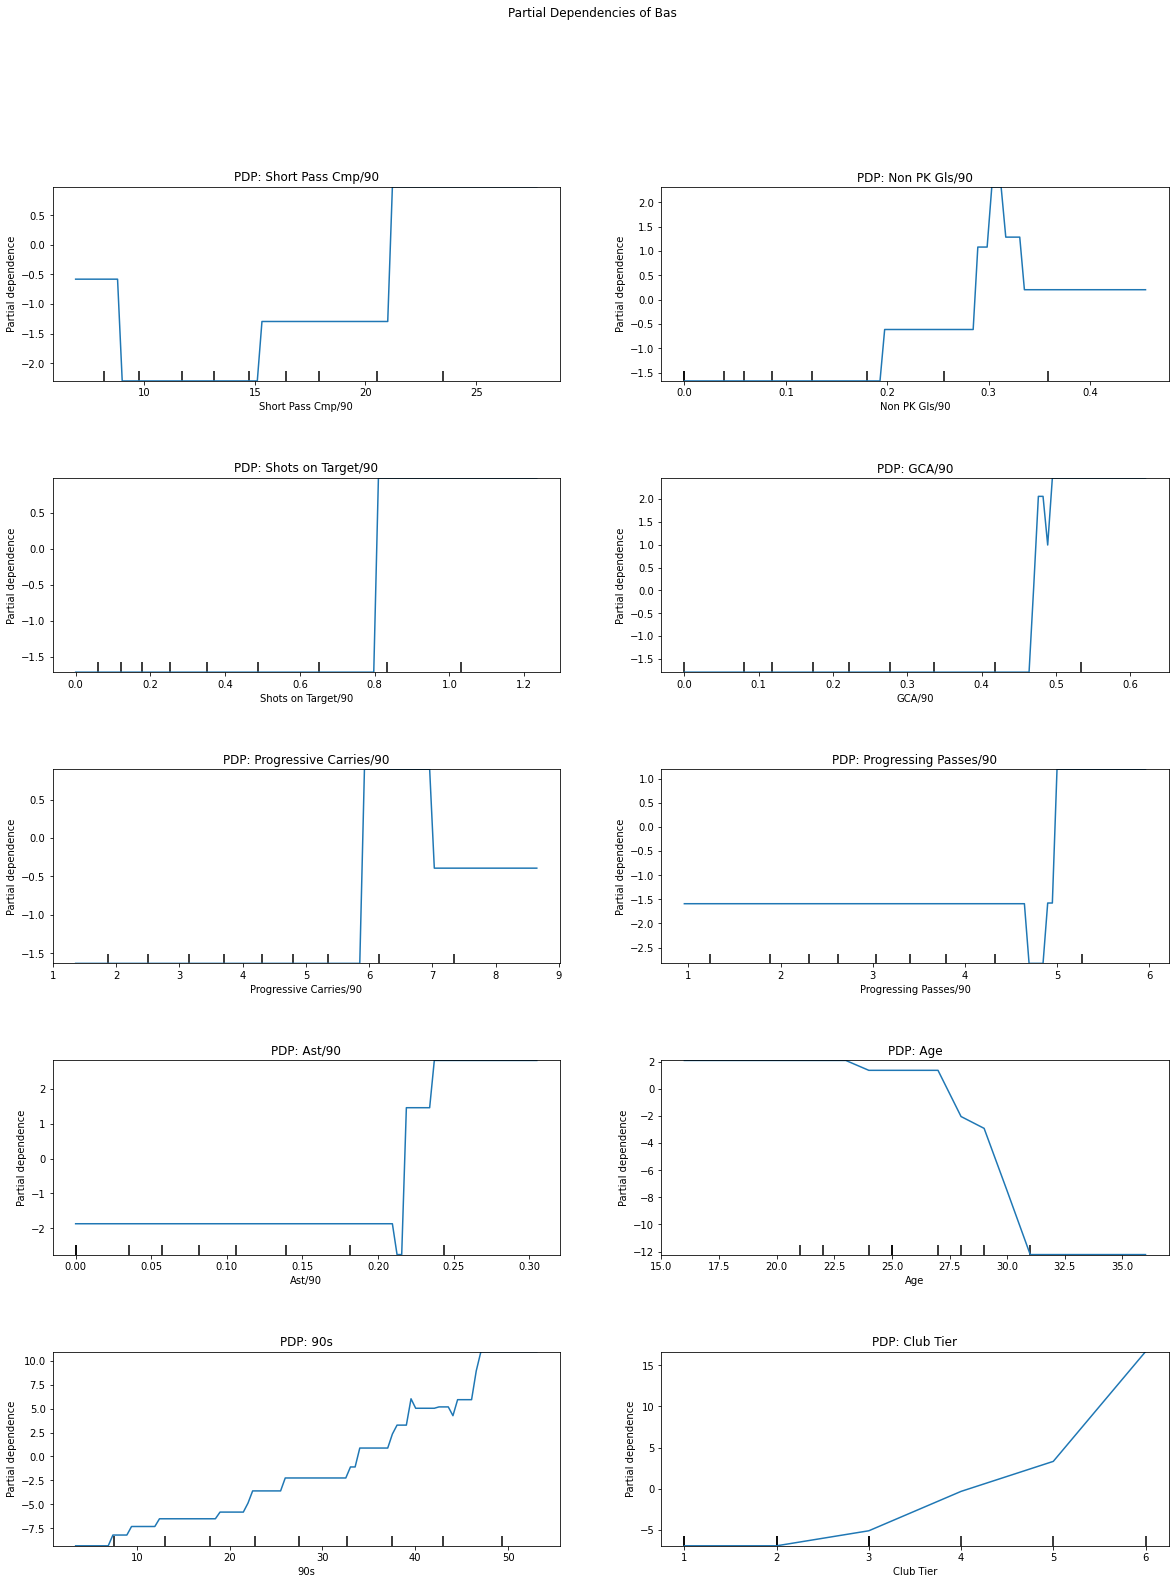

In [ ]:
#pltting pdps of top 10 stats
plt.figure(figsize = (20, 25))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Partial Dependencies of Top 10 Stats')

for n, top_stat in enumerate(top_10_cols_gb):
    ax = plt.subplot(5, 2, n + 1)
    pdp = PartialDependenceDisplay.from_estimator(optimal_gb, X_train, [top_stat], ax=ax)
    ax.set_title('PDP: '+ top_stat)
    

Again we can see that most of the varaibility is accounted for by `Club Tier`, `90s`. For the other statistics, these are helpful to see what elite players produce, or in the case of `Age`, when players start to become less valuable. Once players reach their thirties, their values start a steep decline. Using `Ast/90` as an example, we can see that players who prodcue 0.25 `Ast/90`, produce assists at an elite level. 

# XG Boost model

Now that a gradient boost model has been, made I am going to try and improve on this method by running the more powerful XGBoost model. I am only going to use the original (untransformed) target set, as I am curious to see if the model is better able to predict higher values when given the full range of market values. 

I will start by running a baseline tree model. 

## Baseline XGBoost Tree Regressor

In [ ]:
#importing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

#instantiating default
tree_xgb_baseline = XGBRegressor()

#fitting on train
tree_xgb_baseline.fit(X_train, y_train)

#scoring
print(tree_xgb_baseline.score(X_train, y_train))
print(tree_xgb_baseline.score(X_test, y_test))

[13:22:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9141719959817093
0.69480058340151


There is some serious over-fitting going on here. I am now going to try and run a grid search to lower fix this problem

## XGBoost Tree Regressor Grid 1

In [ ]:
#fitting estimators
tree_xgb_estimators_1 = [("scaling", MinMaxScaler()),
                         ("model", XGBRegressor())]

#creating pipeling
tree_xgb_pipe_1 = Pipeline(tree_xgb_estimators_1)

#creating parameter lists
eta = np.arange(1, 6, 2)/100
max_depth = np.arange(1, 10, 4)
min_child_weight = np.arange(1, 22, 10)
sub_sample = np.arange(25, 76, 25)/100
col_sample = np.arange(25, 76, 25)/100
alpha = [0.1, 1, 10]

#creating param grid
tree_xgb_param_grid_1 = {"scaling": [MinMaxScaler(), None],
                         'model__verbosity': [2],
                         'model__eta': eta, 
                         'model__max_depth': max_depth,
                         'model__min_child_weight': min_child_weight,
                         'model__subsample': sub_sample,
                         'model__colsample_bytree': col_sample,
                         'model__alpha': alpha}


#creating gridsearch
tree_xgb_grid_1 = GridSearchCV(tree_xgb_pipe_1, tree_xgb_param_grid_1)

#fitting grid
fitted_tree_xgb_grid_1 = tree_xgb_grid_1.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
[16:06:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:06:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:06:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:06:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:06:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:06:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:06:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:06:03] INFO: /workspace/src/tree/updater_prune.cc

KeyboardInterrupt: ignored

Streaming output truncated to the last 5000 lines.
[16:37:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[16:37:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[16:37:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[16:37:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[16:37:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[16:37:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[16:37:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[16:37:35] INFO: /workspace/src/tree/updater_p

In [ ]:
#checking best parameters
fitted_tree_xgb_grid_1.best_params_

{'model__alpha': 0.1,
 'model__colsample_bytree': 0.75,
 'model__eta': 0.01,
 'model__max_depth': 5,
 'model__min_child_weight': 21,
 'model__subsample': 0.75,
 'model__verbosity': 2,
 'scaling': MinMaxScaler()}

In [ ]:
#scoring
tree_xgb_train_score1 = fitted_tree_xgb_grid_1.score(X_train, y_train)
tree_xgb_test_score1 = fitted_tree_xgb_grid_1.score(X_test, y_test)

print(f"Training score = {round(tree_xgb_train_score1 * 100, 2)}%")
print(f"Test score = {round(tree_xgb_test_score1 * 100, 2)}%")

Training score = 89.78%
Test score = 66.03%


The model is less over fit and the test score has increased to **67.83%**. It is important to note that this is on the original/untransformed data set. This is far better than any scores on the original target variable data set thus far.  

Every single parameter is at the upper limit that I set, except for *max_depth*. I am going to start at these values, but expand the range considerably in my next grid. I will continue to use only three options for each parameter to keep run times down. I am going to continue to test scaling until I get away from the upper levels of the parameter ranges. 

For max_depth, I now realize that this was relatively small range so I am still going to expand it out, but keep 5 as lower limit. I am also going to add an early stopping rounds set to 20, so if there is 20 iterations without improvement the model will stop. 

## XGBoost Tree Regressor Grid 2

In [ ]:
#This takes about 60 minutes to run
#fitting estimators
tree_xgb_estimators_2 = [("scaling", MinMaxScaler()),
                         ("model", XGBRegressor())]

#creating pipeling
tree_xgb_pipe_2 = Pipeline(tree_xgb_estimators_2)

#creating parameter lists
eta = np.arange(5, 46, 20)/100
max_depth = np.arange(5, 46, 20)
min_child_weight = np.arange(21, 62, 20)
sub_sample = np.arange(65, 86, 10)/100
col_sample = np.arange(65, 86, 10)/100
alpha = [0.1, 0.25, 0.5, 0.75]

#creating param grid
tree_xgb_param_grid_2 = {"scaling": [MinMaxScaler(), None],
                         'model__verbosity': [2],
                         'model__eta': eta, 
                         'model__max_depth': max_depth,
                         'model__min_child_weight': min_child_weight,
                         'model__subsample': sub_sample,
                         'model__colsample_bytree': col_sample,
                         'model__alpha': alpha}


#creating gridsearch
tree_xgb_grid_2 = GridSearchCV(tree_xgb_pipe_2, tree_xgb_param_grid_2)

#fitting grid
fitted_tree_xgb_grid_2 = tree_xgb_grid_2.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
[20:28:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[20:28:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[20:28:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[20:28:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[20:28:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[20:28:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[20:28:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[20:28:10] INFO: /workspace/src/tree/updater_p

In [ ]:
#first parameter set
print('First Parameter Set')
print(fitted_tree_xgb_grid_1.best_params_)
print('___________________________________')

#second parameter set
print('')
print('Second Parameter Set')
print('___________________________________')
print(fitted_tree_xgb_grid_2.best_params_)

First Parameter Set
{'model__alpha': 0.1, 'model__colsample_bytree': 0.75, 'model__eta': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 21, 'model__subsample': 0.75, 'model__verbosity': 2, 'scaling': MinMaxScaler()}
___________________________________

Second Parameter Set
___________________________________
{'model__alpha': 0.1, 'model__colsample_bytree': 0.85, 'model__eta': 0.05, 'model__max_depth': 5, 'model__min_child_weight': 21, 'model__subsample': 0.65, 'model__verbosity': 2, 'scaling': MinMaxScaler()}


In [ ]:
#scoring
tree_xgb_train_score2 = fitted_tree_xgb_grid_2.score(X_train, y_train)
tree_xgb_test_score2 = fitted_tree_xgb_grid_2.score(X_test, y_test)

print(f"Training score = {round(tree_xgb_train_score2 * 100, 2)}%")
print(f"Test score = {round(tree_xgb_test_score2 * 100, 2)}%")
print(f"Previous Test score = {round(tree_xgb_test_score1 * 100, 2)}%")

Training score = 89.18%
Test score = 67.69%
Previous Test score = 66.03%


The test accuracy increased by more than **1.5%** to **67.69%**.

The *columnn subsample* and *eta* increased and the subsampe of features increased. These ranges will shift accordingly to find the optimal hyper parameters. Scaled data has perfomred better in both grid searches, so I will hard code it in for the next model. The other parameters will tested with a tightened range to find their optimal settings. 

This is the last XGBoost model I was able to run due to time constraints and technical difficulties. This model has produced promising results. I will return to XGBoosts in the future